In [5]:
!pip install -q flwr

In [6]:
!pip install -U flwr

In [7]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import gc
import time
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedProx

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def compile_model():
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(1e-5),
        loss=rmse,
        metrics=['accuracy', 'mae', rmse]
    )
    return model

def split_data(num_clients):
    size = len(y_train) // num_clients
    return [
        (X_audio_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_train[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)

def get_model_size(weights):
    return sum([w.nbytes for w in weights])

# --- Flower Client ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio_c, X_text_c, y_c):
        self.model = model
        self.X_audio_train = X_audio_c
        self.X_text_train = X_text_c
        self.y_train = y_c
        self.X_audio_test = X_audio_dev
        self.X_text_test = X_text_dev
        self.y_test = y_dev

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(
            [self.X_audio_train, self.X_text_train],
            self.y_train,
            batch_size=16,
            epochs=2,
            verbose=0,
            shuffle=True,
        )
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate(
            [self.X_audio_test, self.X_text_test], self.y_test, verbose=0
        )
        return float(loss), len(self.y_test), {
            "accuracy": float(acc),
            "mae": float(mae),
            "rmse": float(rmse_val)
        }

# --- Simulation loop over multiple proximal_mu ---
results = {}
proximal_mu_values = [0.0, 0.01, 0.1, 0.5]

for proximal_mu in proximal_mu_values:
    print(f"\n🚀 Testing FedProx with proximal_mu = {proximal_mu}")

    global_metrics = {
        "accuracy": [],
        "mae": [],
        "rmse": [],
        "f1_score": [],
        "precision": [],
        "recall": [],
        "comm_bytes": [],
        "round_time_sec": []
    }

    # --- Client App ---
    def client_fn(context: Context):
        partition_id = int(context.node_config.get("partition-id", 0))
        model = compile_model()
        X_audio_c, X_text_c, y_c = client_datasets[partition_id]
        return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

    client_app = fl.client.ClientApp(client_fn=client_fn)

    # --- Server App ---
    def server_fn(context: Context) -> ServerAppComponents:
        model = compile_model()

        def evaluate_fn(server_round, parameters, _config):
            start = time.time()

            model.set_weights(parameters)
            y_pred = model.predict([X_audio_test, X_text_test], verbose=0)
            y_pred_labels = (y_pred > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred_labels)
            f1 = f1_score(y_test, y_pred_labels)
            prec = precision_score(y_test, y_pred_labels)
            rec = recall_score(y_test, y_pred_labels)
            mae_val = np.mean(np.abs(y_test - y_pred))
            rmse_val = np.sqrt(np.mean((y_test - y_pred) ** 2))

            bytes_per_round = get_model_size(parameters) * NUM_CLIENTS * 2
            round_time = time.time() - start

            global_metrics["accuracy"].append(acc)
            global_metrics["mae"].append(mae_val)
            global_metrics["rmse"].append(rmse_val)
            global_metrics["f1_score"].append(f1)
            global_metrics["precision"].append(prec)
            global_metrics["recall"].append(rec)
            global_metrics["comm_bytes"].append(bytes_per_round)
            global_metrics["round_time_sec"].append(round_time)

            print(f"📊 Round {server_round} — Acc: {acc:.4f}, F1: {f1:.4f}, MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}")

            tf.keras.backend.clear_session()
            gc.collect()

            return float(rmse_val), {
                "accuracy": float(acc),
                "f1_score": float(f1),
                "precision": float(prec),
                "recall": float(rec),
                "mae": float(mae_val),
                "rmse": float(rmse_val),
                "comm_bytes": bytes_per_round,
                "round_time_sec": round_time
            }

        strategy = FedProx(
            fraction_fit=0.8,
            fraction_evaluate=0.5,
            min_fit_clients=NUM_CLIENTS,
            min_evaluate_clients=5,
            min_available_clients=NUM_CLIENTS,
            evaluate_fn=evaluate_fn,
            proximal_mu=proximal_mu,
        )

        return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

    server_app = ServerApp(server_fn=server_fn)

    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
    fl.simulation.run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_config=backend_config,
    )

    results[proximal_mu] = global_metrics



🚀 Testing FedProx with proximal_mu = 0.0


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=50145) 2025-07-04 20:51:51.059629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=50145) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=50145) E0000 00:00:1751662311.153197   50145 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=50145) E0000 00:00:1751662311.183243   50145 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=50147) 2025-07-04 20:52:01.721675: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.5115, F1: 0.4569, MAE: 0.5000, RMSE: 0.5003


INFO :      initial parameters (loss, other metrics): 0.5002561211585999, {'accuracy': 0.5114942528735632, 'f1_score': 0.45686900958466453, 'precision': 0.5143884892086331, 'recall': 0.4109195402298851, 'mae': 0.5000061988830566, 'rmse': 0.5002561211585999, 'comm_bytes': 26125280, 'round_time_sec': 10.195868015289307}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=50145) 2025-07-04 20:52:17.896266: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=50138) 2025-07-04 20:52:17.871903: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5122, F1: 0.4251, MAE: 0.4998, RMSE: 0.5006


INFO :      fit progress: (1, 0.5006042718887329, {'accuracy': 0.5122126436781609, 'f1_score': 0.42506350550381033, 'precision': 0.5175257731958763, 'recall': 0.36063218390804597, 'mae': 0.49984005093574524, 'rmse': 0.5006042718887329, 'comm_bytes': 26125280, 'round_time_sec': 8.455819606781006}, 714.4346267029996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.5108, F1: 0.4134, MAE: 0.4987, RMSE: 0.5009


INFO :      fit progress: (2, 0.5009413361549377, {'accuracy': 0.5107758620689655, 'f1_score': 0.41343669250646, 'precision': 0.5161290322580645, 'recall': 0.3448275862068966, 'mae': 0.4987335205078125, 'rmse': 0.5009413361549377, 'comm_bytes': 26125280, 'round_time_sec': 8.189214706420898}, 1485.6725513239999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 3 — Acc: 0.5187, F1: 0.4234, MAE: 0.4966, RMSE: 0.5016


INFO :      fit progress: (3, 0.5015745162963867, {'accuracy': 0.5186781609195402, 'f1_score': 0.423407917383821, 'precision': 0.5278969957081545, 'recall': 0.35344827586206895, 'mae': 0.4965560734272003, 'rmse': 0.5015745162963867, 'comm_bytes': 26125280, 'round_time_sec': 7.666577577590942}, 2310.9190711810006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 155 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=50148) 2025-07-04 20:52:17.870178: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(raylet) Spilled 5020 MiB, 5 objects, write throughput 216 MiB/s.
INFO :      aggregate_fit: received 10 results and 

📊 Round 4 — Acc: 0.5165, F1: 0.4253, MAE: 0.4950, RMSE: 0.5035


INFO :      fit progress: (4, 0.5035086274147034, {'accuracy': 0.5165229885057471, 'f1_score': 0.4252775405636208, 'precision': 0.5242105263157895, 'recall': 0.3577586206896552, 'mae': 0.49501457810401917, 'rmse': 0.5035086274147034, 'comm_bytes': 26125280, 'round_time_sec': 7.512188196182251}, 3083.809513188)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.5187, F1: 0.4264, MAE: 0.4948, RMSE: 0.5058


INFO :      fit progress: (5, 0.5057956576347351, {'accuracy': 0.5186781609195402, 'f1_score': 0.4263698630136986, 'precision': 0.527542372881356, 'recall': 0.3577586206896552, 'mae': 0.49480047821998596, 'rmse': 0.5057956576347351, 'comm_bytes': 26125280, 'round_time_sec': 7.194838047027588}, 3867.577078759001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 9037 MiB, 9 objects, write throughput 223 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 3924.55s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5255323648452759
INFO :      		round 2: 0.5264251828193665
INFO :      		round 3: 0.5271172523498535
INFO :      		round 4: 0.5281381607055664
INFO :      		round 5: 0.5295374393463135
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5002561211585999
INFO :      		round 1: 0.5006042718887329
INFO :      		round 2:


🚀 Testing FedProx with proximal_mu = 0.01


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=62526) 2025-07-04 21:57:52.118839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=62526) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=62526) E0000 00:00:1751666272.228822   62526 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=62526) E0000 00:00:1751666272.261712   62526 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=62533) 2025-07-04 21:58:03.107184: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.4770, F1: 0.4607, MAE: 0.5001, RMSE: 0.5008


INFO :      initial parameters (loss, other metrics): 0.5008404850959778, {'accuracy': 0.47701149425287354, 'f1_score': 0.46074074074074073, 'precision': 0.47553516819571867, 'recall': 0.4468390804597701, 'mae': 0.5001430511474609, 'rmse': 0.5008404850959778, 'comm_bytes': 26125280, 'round_time_sec': 10.148411273956299}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=62529) 2025-07-04 21:58:17.108967: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=62526) 2025-07-04 21:58:17.150600: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.4820, F1: 0.5491, MAE: 0.5007, RMSE: 0.5017


INFO :      fit progress: (1, 0.5016531944274902, {'accuracy': 0.48204022988505746, 'f1_score': 0.5490931832395247, 'precision': 0.48615725359911405, 'recall': 0.6307471264367817, 'mae': 0.5006692409515381, 'rmse': 0.5016531944274902, 'comm_bytes': 26125280, 'round_time_sec': 8.338633060455322}, 767.0102480919995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.4562, F1: 0.5181, MAE: 0.5028, RMSE: 0.5052


INFO :      fit progress: (2, 0.5051853060722351, {'accuracy': 0.4561781609195402, 'f1_score': 0.5181413112667091, 'precision': 0.46514285714285714, 'recall': 0.5847701149425287, 'mae': 0.502806544303894, 'rmse': 0.5051853060722351, 'comm_bytes': 26125280, 'round_time_sec': 8.695372343063354}, 1540.2704677479996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 4016 MiB, 4 objects, write throughput 203 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=62528) 2025-07-04 21:58:17.134166: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(raylet) Spilled 6024 MiB, 6 objects, write throughput 280 MiB/s.
INFO :      aggregate_fit: received 10 results and 

📊 Round 3 — Acc: 0.4641, F1: 0.4754, MAE: 0.5073, RMSE: 0.5126


INFO :      fit progress: (3, 0.5125851631164551, {'accuracy': 0.4640804597701149, 'f1_score': 0.47538677918424754, 'precision': 0.465564738292011, 'recall': 0.48563218390804597, 'mae': 0.5072620511054993, 'rmse': 0.5125851631164551, 'comm_bytes': 26125280, 'round_time_sec': 7.896056175231934}, 2327.489107726)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 9037 MiB, 9 objects, write throughput 277 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.4497, F1: 0.4170, MAE: 0.5116, RMSE: 0.5209


INFO :      fit progress: (4, 0.5209074020385742, {'accuracy': 0.44971264367816094, 'f1_score': 0.4170471841704718, 'precision': 0.44336569579288027, 'recall': 0.3936781609195402, 'mae': 0.5116130709648132, 'rmse': 0.5209074020385742, 'comm_bytes': 26125280, 'round_time_sec': 7.737585544586182}, 3113.9127076719997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.4555, F1: 0.3946, MAE: 0.5141, RMSE: 0.5269


INFO :      fit progress: (5, 0.5269414782524109, {'accuracy': 0.45545977011494254, 'f1_score': 0.3945686900958466, 'precision': 0.4442446043165468, 'recall': 0.35488505747126436, 'mae': 0.5141368508338928, 'rmse': 0.5269414782524109, 'comm_bytes': 26125280, 'round_time_sec': 8.075779914855957}, 3898.991341519999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 3948.45s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5261014103889465
INFO :      		round 2: 0.5286839008331299
INFO :      		round 3: 0.5343691110610962
INFO :      		round 4: 0.5403514504432678
INFO :      		round 5: 0.543881893157959
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5008404850959778
INFO :      		round 1: 0.5016531944274902
INFO :      		round 2: 0.5051853060722351
INFO :      		round 3: 0.5125851631164551
INF


🚀 Testing FedProx with proximal_mu = 0.1


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=74918) 2025-07-04 23:04:16.941886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=74918) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=74918) E0000 00:00:1751670257.064834   74918 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=74917) E0000 00:00:1751670257.074376   74917 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=74919) 2025-07-04 23:04:26.723247: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.5216, F1: 0.3019, MAE: 0.4985, RMSE: 0.4992


INFO :      initial parameters (loss, other metrics): 0.49921882152557373, {'accuracy': 0.521551724137931, 'f1_score': 0.3018867924528302, 'precision': 0.5581395348837209, 'recall': 0.20689655172413793, 'mae': 0.498494416475296, 'rmse': 0.49921882152557373, 'comm_bytes': 26125280, 'round_time_sec': 9.740636110305786}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=74918) 2025-07-04 23:04:40.258213: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=74917) 2025-07-04 23:04:40.220829: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5093, F1: 0.3961, MAE: 0.4975, RMSE: 0.4991


INFO :      fit progress: (1, 0.4990551471710205, {'accuracy': 0.5093390804597702, 'f1_score': 0.3961096374889478, 'precision': 0.5149425287356322, 'recall': 0.3218390804597701, 'mae': 0.49752676486968994, 'rmse': 0.4990551471710205, 'comm_bytes': 26125280, 'round_time_sec': 8.024769067764282}, 737.5736090969986)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.5079, F1: 0.4038, MAE: 0.4952, RMSE: 0.4997


INFO :      fit progress: (2, 0.4996931850910187, {'accuracy': 0.5079022988505747, 'f1_score': 0.40382941688424717, 'precision': 0.5121412803532008, 'recall': 0.3333333333333333, 'mae': 0.49523839354515076, 'rmse': 0.4996931850910187, 'comm_bytes': 26125280, 'round_time_sec': 8.222648620605469}, 1504.5521720189972)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 209 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=74922) 2025-07-04 23:04:40.277830: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(raylet) Spilled 5020 MiB, 5 objects, write throughput 286 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results an

📊 Round 3 — Acc: 0.5086, F1: 0.4154, MAE: 0.4924, RMSE: 0.5026


INFO :      fit progress: (3, 0.5025871396064758, {'accuracy': 0.5086206896551724, 'f1_score': 0.4153846153846154, 'precision': 0.5126582278481012, 'recall': 0.34913793103448276, 'mae': 0.49244430661201477, 'rmse': 0.5025871396064758, 'comm_bytes': 26125280, 'round_time_sec': 8.263776302337646}, 2275.563924189999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 10041 MiB, 10 objects, write throughput 311 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.5072, F1: 0.4167, MAE: 0.4903, RMSE: 0.5071


INFO :      fit progress: (4, 0.5070902109146118, {'accuracy': 0.507183908045977, 'f1_score': 0.4166666666666667, 'precision': 0.5104166666666666, 'recall': 0.35201149425287354, 'mae': 0.4903041422367096, 'rmse': 0.5070902109146118, 'comm_bytes': 26125280, 'round_time_sec': 7.69696569442749}, 3058.3776204349997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 17070 MiB, 17 objects, write throughput 318 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.5057, F1: 0.4130, MAE: 0.4892, RMSE: 0.5107


INFO :      fit progress: (5, 0.5106826424598694, {'accuracy': 0.5057471264367817, 'f1_score': 0.41296928327645055, 'precision': 0.5084033613445378, 'recall': 0.34770114942528735, 'mae': 0.48919185996055603, 'rmse': 0.5106826424598694, 'comm_bytes': 26125280, 'round_time_sec': 7.8315589427948}, 3860.8597876799977)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 3910.81s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5274575352668762
INFO :      		round 2: 0.5321348309516907
INFO :      		round 3: 0.5379828214645386
INFO :      		round 4: 0.5428155064582825
INFO :      		round 5: 0.5448662638664246
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.49921882152557373
INFO :      		round 1: 0.4990551471710205
INFO :      		round 2: 0.4996931850910187
INFO :      		round 3: 0.5025871396064758
I


🚀 Testing FedProx with proximal_mu = 0.5


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=87312) 2025-07-05 00:10:03.123335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=87312) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=87312) E0000 00:00:1751674203.204301   87312 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=87312) E0000 00:00:1751674203.228026   87312 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=87310) 2025-07-05 00:10:12.573092: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.5237, F1: 0.5595, MAE: 0.5000, RMSE: 0.5012


INFO :      initial parameters (loss, other metrics): 0.5012194514274597, {'accuracy': 0.5237068965517241, 'f1_score': 0.559468438538206, 'precision': 0.5203955500618047, 'recall': 0.6048850574712644, 'mae': 0.5000282526016235, 'rmse': 0.5012194514274597, 'comm_bytes': 26125280, 'round_time_sec': 9.68580961227417}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=87312) 2025-07-05 00:10:26.500073: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=87309) 2025-07-05 00:10:26.482686: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5036, F1: 0.4529, MAE: 0.5005, RMSE: 0.5024


INFO :      fit progress: (1, 0.502366304397583, {'accuracy': 0.5035919540229885, 'f1_score': 0.45288994457640536, 'precision': 0.5044091710758377, 'recall': 0.4109195402298851, 'mae': 0.5005109310150146, 'rmse': 0.502366304397583, 'comm_bytes': 26125280, 'round_time_sec': 7.727035284042358}, 753.7558807079986)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 212 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=87307) 2025-07-05 00:10:26.492629: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(raylet) Spilled 5020 MiB, 5 objects, write throughput 324 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 

📊 Round 2 — Acc: 0.4950, F1: 0.4185, MAE: 0.5021, RMSE: 0.5066


INFO :      fit progress: (2, 0.5065546035766602, {'accuracy': 0.4949712643678161, 'f1_score': 0.4185277088502895, 'precision': 0.49317738791423, 'recall': 0.3635057471264368, 'mae': 0.5021392703056335, 'rmse': 0.5065546035766602, 'comm_bytes': 26125280, 'round_time_sec': 7.565788984298706}, 1539.138040935999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 3 — Acc: 0.4928, F1: 0.4146, MAE: 0.5053, RMSE: 0.5144


INFO :      fit progress: (3, 0.5143716335296631, {'accuracy': 0.492816091954023, 'f1_score': 0.41459369817578773, 'precision': 0.49019607843137253, 'recall': 0.35919540229885055, 'mae': 0.5052874684333801, 'rmse': 0.5143716335296631, 'comm_bytes': 26125280, 'round_time_sec': 7.596996784210205}, 2309.8833871419993)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 10041 MiB, 10 objects, write throughput 285 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.4828, F1: 0.4127, MAE: 0.5087, RMSE: 0.5229


INFO :      fit progress: (4, 0.5229254364967346, {'accuracy': 0.4827586206896552, 'f1_score': 0.41272430668841764, 'precision': 0.47735849056603774, 'recall': 0.3635057471264368, 'mae': 0.5087151527404785, 'rmse': 0.5229254364967346, 'comm_bytes': 26125280, 'round_time_sec': 7.725661516189575}, 3096.624845135)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.4749, F1: 0.4147, MAE: 0.5105, RMSE: 0.5278


INFO :      fit progress: (5, 0.5277516841888428, {'accuracy': 0.47485632183908044, 'f1_score': 0.41473178542834266, 'precision': 0.46835443037974683, 'recall': 0.37212643678160917, 'mae': 0.5105360150337219, 'rmse': 0.5277516841888428, 'comm_bytes': 26125280, 'round_time_sec': 7.562784910202026}, 3883.6594234250006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 3933.33s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5254865884780884
INFO :      		round 2: 0.5271960496902466
INFO :      		round 3: 0.5291243195533752
INFO :      		round 4: 0.5303255915641785
INFO :      		round 5: 0.5312092900276184
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5012194514274597
INFO :      		round 1: 0.502366304397583
INFO :      		round 2: 0.5065546035766602
INFO :      		round 3: 0.5143716335296631


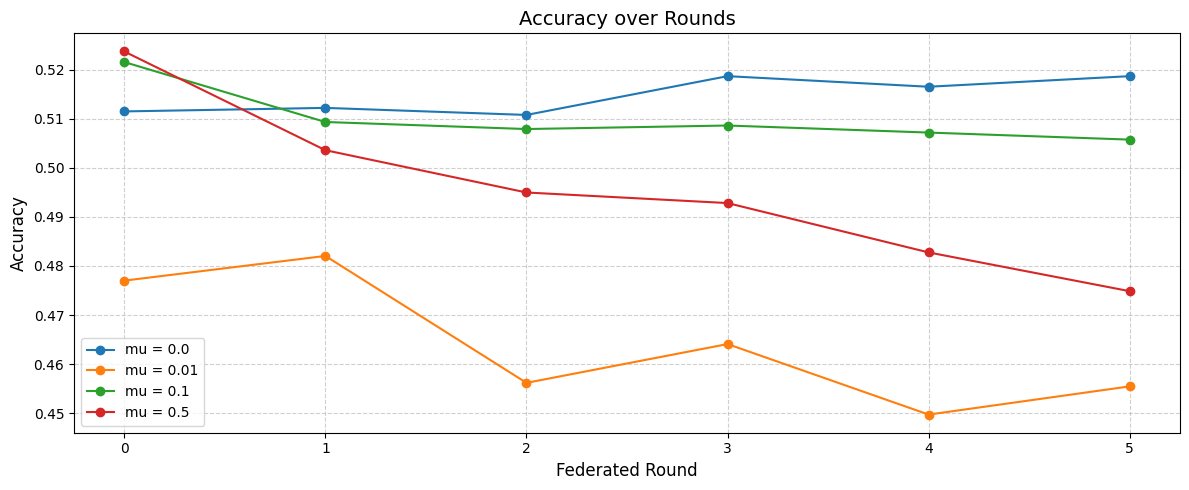

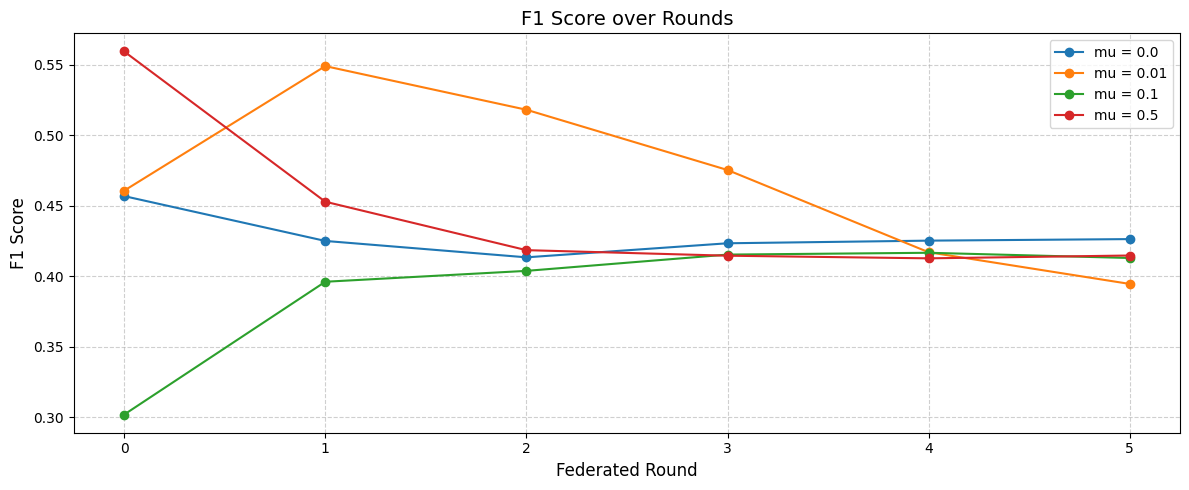

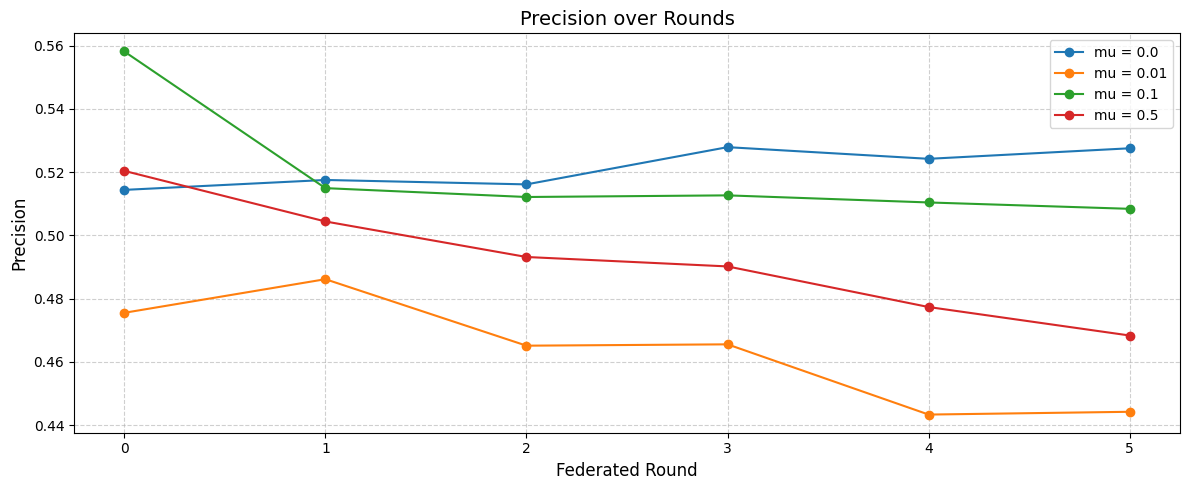

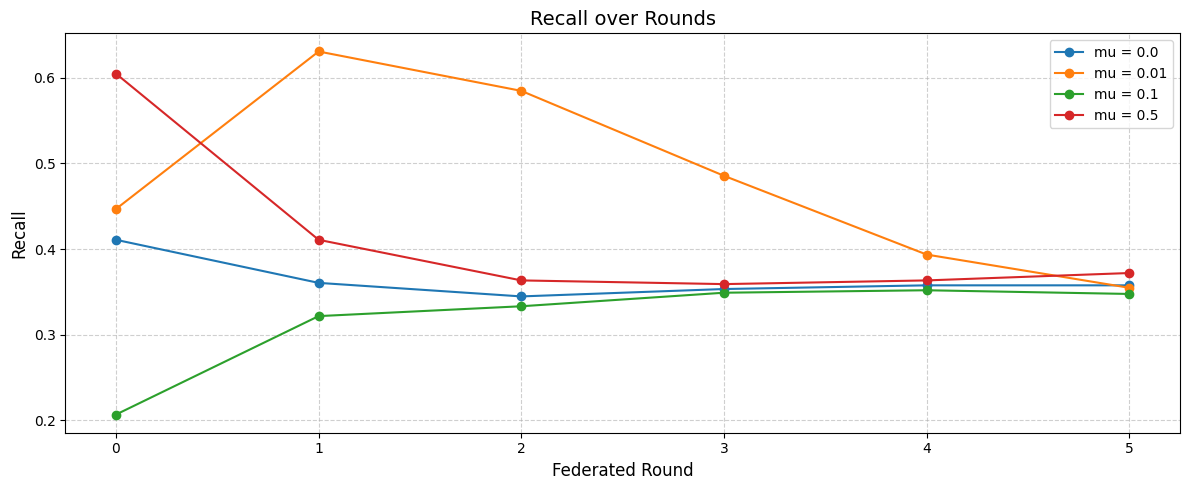

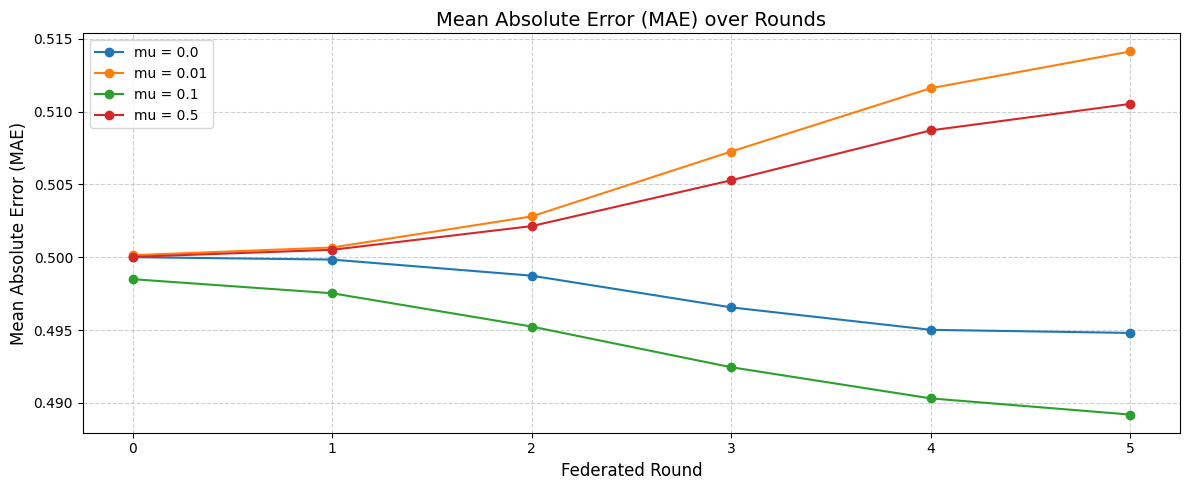

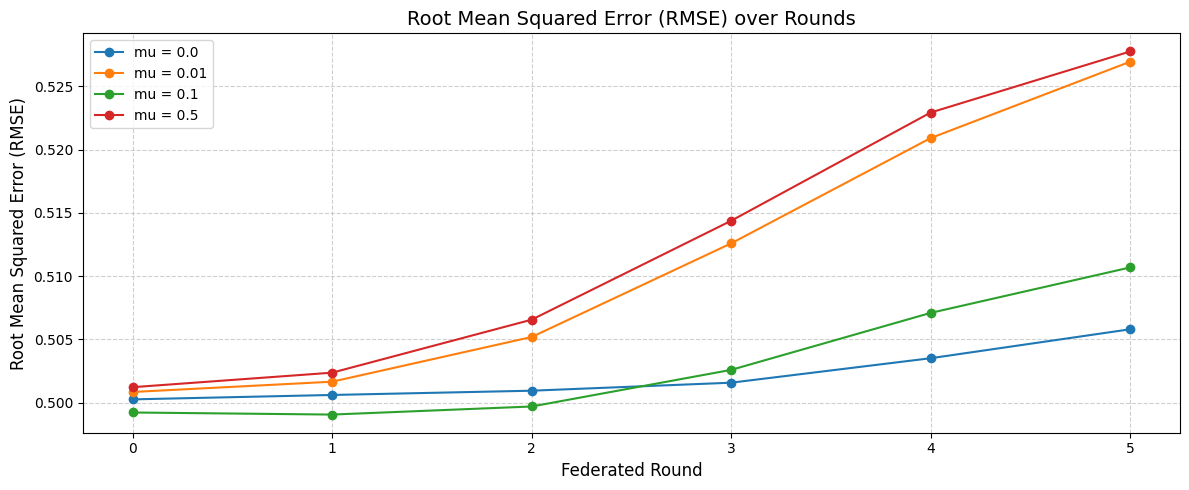

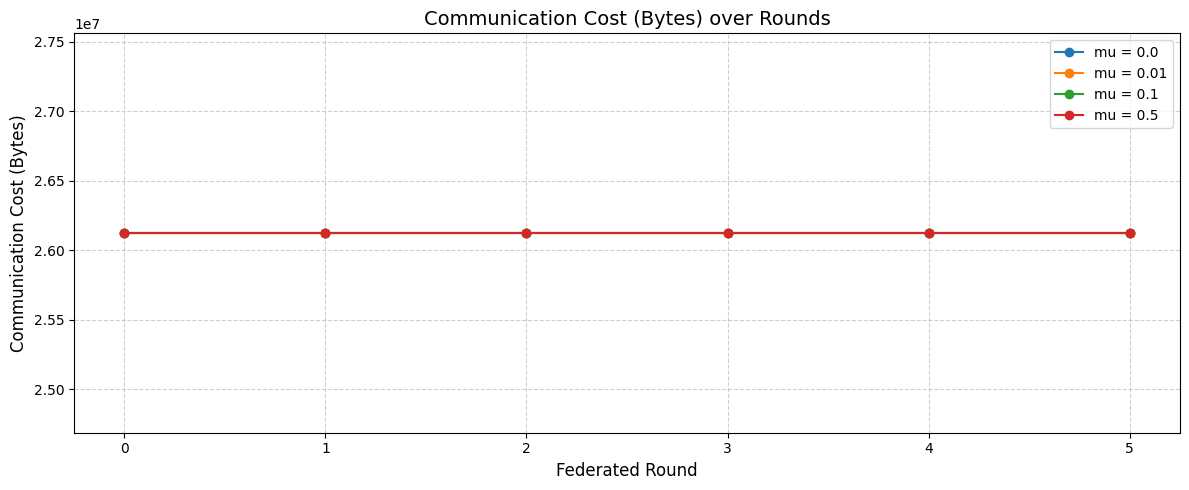

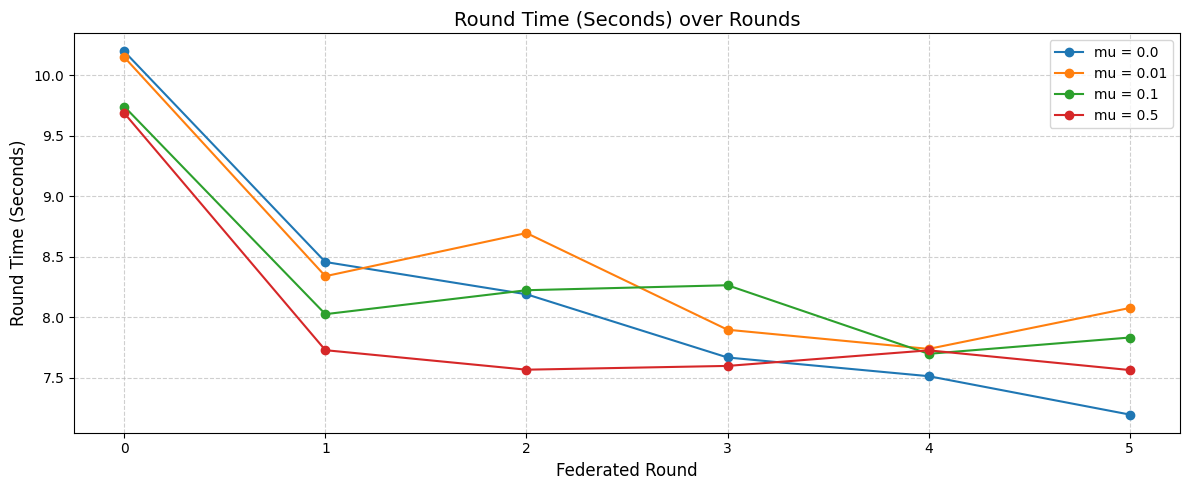

In [8]:
# --- Plotting and Saving Results ---
import matplotlib.pyplot as plt
import pandas as pd

# Liste des métriques à tracer
all_metrics = [
    "accuracy", "f1_score", "precision", "recall",
    "mae", "rmse", "comm_bytes", "round_time_sec"
]

# Titres jolis pour chaque métrique
metric_titles = {
    "accuracy": "Accuracy",
    "f1_score": "F1 Score",
    "precision": "Precision",
    "recall": "Recall",
    "mae": "Mean Absolute Error (MAE)",
    "rmse": "Root Mean Squared Error (RMSE)",
    "comm_bytes": "Communication Cost (Bytes)",
    "round_time_sec": "Round Time (Seconds)"
}

# 1. Tracer toutes les métriques et sauvegarder en PNG
for metric in all_metrics:
    plt.figure(figsize=(12, 5))
    for mu, (metrics_dict) in results.items():
        plt.plot(metrics_dict[metric], marker='o', label=f"mu = {mu}")
    plt.title(f"{metric_titles[metric]} over Rounds", fontsize=14)
    plt.xlabel("Federated Round", fontsize=12)
    plt.ylabel(metric_titles[metric], fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{metric}_fedprox_comparison.png")
    plt.show()

# 2. Exporter les résultats de chaque mu en fichier CSV
for mu, (metrics_dict) in results.items():
    df = pd.DataFrame(metrics_dict)
    df.to_csv(f"fedprox_mu_{mu}.csv", index=False)
